In [5]:
from pathlib import Path
from dataclasses import dataclass, asdict

@dataclass
class CFG:
    train_path: Path = Path("../data/train.csv")
    test_path: Path = Path("../data/test.csv")
    sub_path: Path = Path("../data/sample_submission.csv")

    num_fold: int = 5
    dev_mode: bool = False

    # Model parameters
    n_iter: int = 10000
    max_depth: int = -1
    num_leaves: int = 1024
    colsample_bytree: float = 0.7
    learning_rate: float = 0.02

    objective: str = 'l2'
    metric: str = 'rmse'
    verbosity: int = -1
    max_bin: int = 1024
    
    random_state: int = 42
    shuffle: bool = True
    encoded_columns_start: int = -91
    log_eval: int = 100
    early_stopping: int = 200
    
cfg = CFG() 
asdict(cfg)

{'train_path': PosixPath('../data/train.csv'),
 'test_path': PosixPath('../data/test.csv'),
 'sub_path': PosixPath('../data/sample_submission.csv'),
 'num_fold': 5,
 'dev_mode': False,
 'n_iter': 10000,
 'max_depth': -1,
 'num_leaves': 1024,
 'colsample_bytree': 0.7,
 'learning_rate': 0.02,
 'objective': 'l2',
 'metric': 'rmse',
 'verbosity': -1,
 'max_bin': 1024,
 'random_state': 42,
 'shuffle': True,
 'encoded_columns_start': -91,
 'log_eval': 100,
 'early_stopping': 200}

In [6]:
from IPython.display import display
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

re_dict = {}
re_dict['podc_dict'] = {
    'Mystery Matters': 0, 'Joke Junction': 1, 'Study Sessions': 2, 'Digital Digest': 3, 
    'Mind & Body': 4, 'Fitness First': 5, 'Criminal Minds': 6, 'News Roundup': 7, 
    'Daily Digest': 8, 'Music Matters': 9, 'Sports Central': 10, 'Melody Mix': 11, 
    'Game Day': 12, 'Gadget Geek': 13, 'Global News': 14, 'Tech Talks': 15, 
    'Sport Spot': 16, 'Funny Folks': 17, 'Sports Weekly': 18, 'Business Briefs': 19, 
    'Tech Trends': 20, 'Innovators': 21, 'Health Hour': 22, 'Comedy Corner': 23, 
    'Sound Waves': 24, 'Brain Boost': 25, "Athlete's Arena": 26, 'Wellness Wave': 27, 
    'Style Guide': 28, 'World Watch': 29, 'Humor Hub': 30, 'Money Matters': 31, 
    'Healthy Living': 32, 'Home & Living': 33, 'Educational Nuggets': 34, 
    'Market Masters': 35, 'Learning Lab': 36, 'Lifestyle Lounge': 37, 
    'Crime Chronicles': 38, 'Detective Diaries': 39, 'Life Lessons': 40, 
    'Current Affairs': 41, 'Finance Focus': 42, 'Laugh Line': 43, 
    'True Crime Stories': 44, 'Business Insights': 45, 'Fashion Forward': 46, 'Tune Time': 47
}
re_dict['genr_dict'] = {'True Crime': 0, 'Comedy': 1, 'Education': 2, 'Technology': 3, 'Health': 4, 'News': 5, 'Music': 6, 'Sports': 7, 'Business': 8, 'Lifestyle': 9}
re_dict['week_dict'] = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
re_dict['time_dict'] = {'Morning': 10, 'Afternoon': 14, 'Evening': 17, 'Night': 21}
re_dict['sent_dict'] = {'Negative': 0, 'Neutral': 1, 'Positive': 2}


def preprocess_df(df):
    df['Episode_Num'] = df['Episode_Title'].str[8:].astype(int)  # Convert to int before log transform
    df = df.drop(columns=['Episode_Title'])

    # Convert categorical variables
    df['Genre'] = df['Genre'].replace(re_dict["genr_dict"])
    df['Podcast_Name'] = df['Podcast_Name'].replace(re_dict["podc_dict"])
    df['Publication_Day'] = df['Publication_Day'].replace(re_dict["week_dict"])
    df['Publication_Time'] = df['Publication_Time'].replace(re_dict["time_dict"])
    df['Episode_Sentiment'] = df['Episode_Sentiment'].replace(re_dict["sent_dict"])

    df.loc[df['Episode_Length_minutes']>121.0, 'Episode_Length_minutes'] = 121.0

    df['Host_Guest_Diff'] = df['Host_Popularity_percentage'] - df['Guest_Popularity_percentage']
    df['Host_Guest_Ratio'] = (df['Host_Popularity_percentage'] / df['Guest_Popularity_percentage']).replace([float('inf'), -float('inf')], pd.NA)

    if "Listening_Time_minutes" in df.columns:
        df['Listening_Episode_Diff'] = df['Episode_Length_minutes'] - df['Listening_Time_minutes']
        df['Listening_Episode_Ratio'] = (df['Episode_Length_minutes'] / df['Listening_Time_minutes']).replace([float('inf'), -float('inf')], pd.NA)

    return df


df_train = pd.read_csv(cfg.train_path, index_col='id')
df_test = pd.read_csv(cfg.test_path, index_col='id')
df_sub = pd.read_csv(cfg.sub_path, index_col='id')

# is_dev_mode = False
# # is_dev_mode = True
# if is_dev_mode:
#     df_train = df_train.sample(10000, random_state=42)
#     df_test = df_test[:10]
#     df_sub = df_sub[:10]
    
df_train = preprocess_df(df_train)
df_test = preprocess_df(df_test)

# target_col = "Listening_Time_minutes"
# y_train = df_train[target_col].copy()
# df_train = df_train.drop(columns=[target_col])

display(df_train)
display(df_train.describe())

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Episode_Num,Host_Guest_Diff,Host_Guest_Ratio,Listening_Episode_Diff,Listening_Episode_Ratio
id,,,,,,,,,,,,,,,
0,0,NaN,0,74.81,3,21,NaN,0.0,2,31.41998,98,NaN,NaN,NaN,NaN
1,1,119.80,1,66.95,5,14,75.95,2.0,0,88.01241,26,-9.00,0.881501,31.78759,1.361172
2,2,73.90,2,69.97,1,17,8.97,0.0,0,44.92531,16,61.00,7.800446,28.97469,1.644952
3,3,67.17,3,57.22,0,10,78.70,2.0,2,46.27824,45,-21.48,0.727065,20.89176,1.451438
4,4,110.51,4,80.07,0,14,58.68,3.0,1,75.61031,86,21.39,1.364519,34.89969,1.461573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,36,75.66,2,69.36,5,10,NaN,0.0,0,56.87058,25,NaN,NaN,18.78942,1.330389
749996,19,75.75,8,35.21,5,21,NaN,2.0,1,45.46242,21,NaN,NaN,30.28758,1.666211
749997,37,30.98,9,78.58,3,10,84.89,0.0,0,15.26000,51,-6.31,0.925669,15.72000,2.030144


,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Episode_Num,Host_Guest_Diff,Listening_Episode_Diff
count,750000.000000,662907.000000,750000.000000,750000.000000,750000.000000,750000.000000,603970.000000,749999.000000,750000.000000,750000.000000,750000.000000,603970.000000,662907.000000
mean,23.540307,64.504430,4.556036,59.859901,3.030805,15.671500,52.236449,1.348855,0.997969,45.437406,51.445811,7.456403,18.766443
std,13.917884,32.968121,2.965912,22.873098,2.024196,4.026379,28.451241,1.151130,0.815440,27.138306,28.085623,36.090841,13.494582
min,0.000000,0.000000,0.000000,1.300000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-80.170000,-115.540000
25%,12.000000,35.730000,2.000000,39.410000,1.000000,14.000000,28.380000,0.000000,0.000000,23.178350,28.000000,-18.390000,8.273530
50%,23.000000,63.840000,5.000000,60.050000,3.000000,17.000000,53.580000,1.000000,1.000000,43.379460,52.000000,6.390000,15.713050
75%,36.000000,94.070000,7.000000,79.530000,5.000000,21.000000,76.600000,2.000000,2.000000,64.811580,75.000000,32.730000,26.710000
max,47.000000,121.000000,9.000000,119.460000,6.000000,21.000000,119.910000,103.910000,2.000000,119.970000,100.000000,113.550000,103.220440


In [ ]:
df_train[df_train["Listening_Time_minutes"] > 3]

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Episode_Num,Host_Guest_Diff,Host_Guest_Ratio,Listening_Episode_Diff,Listening_Episode_Ratio
id,,,,,,,,,,,,,,,
211159,27,64.83,4,48.46,6,17,NaN,53.37,2,50.44892,83,NaN,NaN,14.38108,1.285062
283606,22,109.93,4,67.81,6,10,77.90,103.91,1,103.89696,15,-10.09,0.870475,6.03304,1.058068
436577,10,115.25,7,28.58,5,14,23.65,103.00,1,103.12686,64,4.93,1.208457,12.12314,1.117556
495919,23,64.83,1,48.37,5,17,NaN,53.42,1,50.44892,79,NaN,NaN,14.38108,1.285062
537705,24,112.27,6,28.95,5,10,10.15,103.75,1,103.12686,64,18.80,2.852217,9.14314,1.088659
567235,39,16.13,0,49.11,1,17,43.17,12.00,2,6.49000,21,5.94,1.137596,9.64000,2.485362
602553,24,112.27,6,28.19,1,10,23.15,103.25,1,103.12686,53,5.04,1.217711,9.14314,1.088659
672139,24,115.74,6,28.95,1,14,23.50,103.25,1,103.12686,35,5.45,1.231915,12.61314,1.122307
683147,38,109.93,0,59.66,1,17,77.91,103.88,1,103.89696,15,-18.25,0.765755,6.03304,1.058068


RMSE score: 2.313134147390121
Base RMSE score: 2.313134147390121
0.97100 RMSE score: 2.99273
0.97200 RMSE score: 2.93495
0.97300 RMSE score: 2.87871
0.97400 RMSE score: 2.82411
0.97500 RMSE score: 2.77126
0.97600 RMSE score: 2.72023
0.97700 RMSE score: 2.67116
0.97800 RMSE score: 2.62413
0.97900 RMSE score: 2.57927
0.98000 RMSE score: 2.53669
0.98100 RMSE score: 2.49651
0.98200 RMSE score: 2.45883
0.98300 RMSE score: 2.42379
0.98400 RMSE score: 2.39150
0.98500 RMSE score: 2.36206
0.98600 RMSE score: 2.33559
0.98700 RMSE score: 2.31220
0.98800 RMSE score: 2.29196
0.98900 RMSE score: 2.27497
0.99000 RMSE score: 2.26130
0.99100 RMSE score: 2.25102
0.99200 RMSE score: 2.24416
0.99300 RMSE score: 2.24076
0.99400 RMSE score: 2.24083
0.99500 RMSE score: 2.24438
0.99600 RMSE score: 2.25139
0.99700 RMSE score: 2.26182
0.99800 RMSE score: 2.27563
0.99900 RMSE score: 2.29276
1.00000 RMSE score: 2.31313
1.00100 RMSE score: 2.33667
1.00200 RMSE score: 2.36326
1.00300 RMSE score: 2.39282
1.00400 RMS

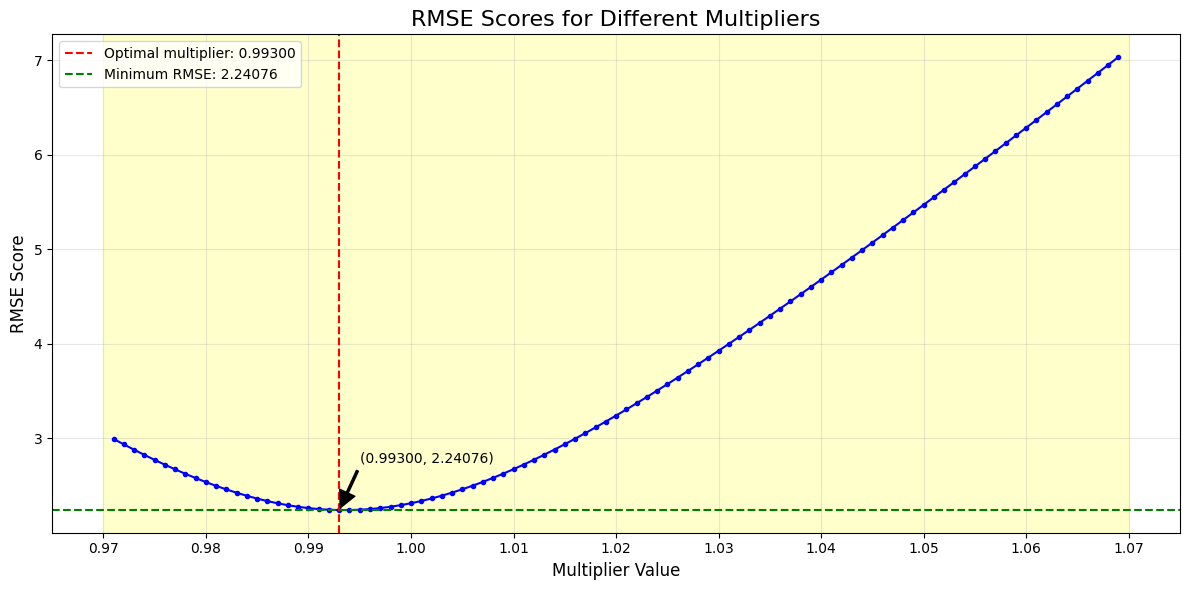


Best multiplier: 0.99300
Best RMSE score: 2.24076
Improvement over base: 0.07238 (3.13%)


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Define the RMSE calculation function
def calc_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

df_over_ads = df_train[df_train["Number_of_Ads"] > 3]
df_over_ads["Pred_Listening_Time_minutes"] = df_over_ads["Number_of_Ads"] * 0.993
print("RMSE score:", calc_rmse(df_over_ads["Listening_Time_minutes"], df_over_ads["Number_of_Ads"]))

# Calculate base RMSE score
base_rmse = calc_rmse(df_over_ads["Listening_Time_minutes"], df_over_ads["Number_of_Ads"])
print("Base RMSE score:", base_rmse)

# Calculate RMSE scores for different multipliers
multipliers = [i / 1000 + 0.97 for i in range(1, 100)]
rmse_scores = []

for v in multipliers:
    rmse = calc_rmse(df_over_ads["Listening_Time_minutes"], df_over_ads["Number_of_Ads"] * v)
    rmse_scores.append(rmse)
    print(f"{v:.5f} RMSE score: {rmse:.5f}")

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(multipliers, rmse_scores, marker='o', linestyle='-', color='blue', markersize=3)
plt.axvline(x=multipliers[np.argmin(rmse_scores)], color='red', linestyle='--', 
            label=f'Optimal multiplier: {multipliers[np.argmin(rmse_scores)]:.5f}')
plt.axhline(y=min(rmse_scores), color='green', linestyle='--', 
            label=f'Minimum RMSE: {min(rmse_scores):.5f}')

plt.title('RMSE Scores for Different Multipliers', fontsize=16)
plt.xlabel('Multiplier Value', fontsize=12)
plt.ylabel('RMSE Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Annotate the minimum point
min_idx = np.argmin(rmse_scores)
plt.annotate(f'({multipliers[min_idx]:.5f}, {rmse_scores[min_idx]:.5f})', 
             xy=(multipliers[min_idx], rmse_scores[min_idx]),
             xytext=(multipliers[min_idx]+0.002, rmse_scores[min_idx]+0.5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

# Highlight the region between 0.97 and 1.07
plt.axvspan(0.97, 1.07, alpha=0.2, color='yellow', label='Search Region')

# Format x-axis to show more detail
plt.xticks(np.linspace(0.97, 1.07, 11))

plt.tight_layout()
plt.show()

# Print the best multiplier and its RMSE score
best_multiplier = multipliers[np.argmin(rmse_scores)]
best_rmse = min(rmse_scores)
print(f"\nBest multiplier: {best_multiplier:.5f}")
print(f"Best RMSE score: {best_rmse:.5f}")
print(f"Improvement over base: {base_rmse - best_rmse:.5f} ({(base_rmse - best_rmse) / base_rmse * 100:.2f}%)")

In [43]:
df_test[df_test["Episode_Length_minutes"]>120.]

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Episode_Num,Host_Guest_Diff,Host_Guest_Ratio
id,,,,,,,,,,,,
804434,41,7575.00,5,89.54,5,21,NaN,2.0,0,36,NaN,NaN
806597,35,78486264.00,8,55.45,0,17,48.50,0.0,2,23,6.95,1.143299
822201,39,120.37,0,79.40,3,14,NaN,0.0,1,81,NaN,NaN
930050,15,120.73,3,50.27,4,14,60.43,0.0,1,23,-10.16,0.831872


<Axes: >

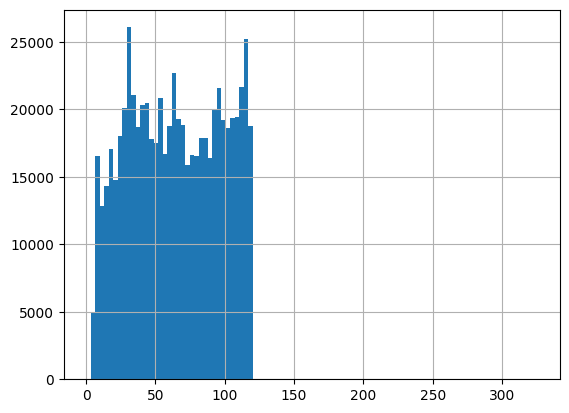

In [32]:
df_train["Episode_Length_minutes"].hist(bins=100)

In [17]:
# Please get only duplicate with Podcast_Name, Episode_Num
df_dup = df_train[df_train.duplicated(subset=['Podcast_Name', 'Host_Popularity_percentage'], keep=False)]
df_dup = df_dup.sort_values(['Podcast_Name', 'Host_Popularity_percentage', 'Guest_Popularity_percentage'])
df_dup

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,
748552,Athlete's Arena,Episode 82,71.02,Sports,20.04,Friday,Afternoon,29.09,0.0,Neutral,56.09749
123261,Athlete's Arena,Episode 82,71.02,Music,20.04,Saturday,Afternoon,78.09,3.0,Positive,56.09749
707023,Athlete's Arena,Episode 82,71.02,Sports,20.04,Friday,Afternoon,78.09,0.0,Positive,56.09749
615974,Athlete's Arena,Episode 19,117.60,Sports,20.04,Sunday,Morning,NaN,2.0,Neutral,78.02501
88755,Athlete's Arena,Episode 63,72.54,Sports,20.06,Friday,Night,14.11,1.0,Negative,39.39000
...,...,...,...,...,...,...,...,...,...,...,...
162218,World Watch,Episode 71,44.50,News,99.89,Saturday,Evening,54.56,1.0,Negative,28.82105
381608,World Watch,Episode 57,16.63,News,99.89,Saturday,Evening,NaN,3.0,Negative,15.20660
491598,World Watch,Episode 50,74.06,News,99.89,Friday,Evening,NaN,2.0,Negative,50.76499


In [ ]:
# Please get only duplicate with Podcast_Name, Episode_Num
df_dup = df_train[df_train.duplicated(subset=['Podcast_Name', 'Episode_Num'], keep=False)]
df_dup = df_dup.sort_values(['Podcast_Name', 'Episode_Num', 'Host_Popularity_percentage', 'Guest_Popularity_percentage'])
df_dup

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Episode_Num
id,,,,,,,,,,
2221,0,55.10,0,68.79,6,14,6.29,1.0,2,1
6639,0,85.75,0,96.60,0,21,9.86,0.0,0,1
12478,0,69.75,0,94.31,4,17,94.08,2.0,0,1
26451,0,63.84,0,95.01,6,10,22.62,0.0,1,1
33972,0,90.33,0,85.02,0,10,27.76,3.0,2,1
...,...,...,...,...,...,...,...,...,...,...
714536,47,50.09,6,67.47,2,10,53.58,0.0,0,100
715096,47,71.71,6,73.30,1,21,53.58,1.0,1,100
717445,47,7.20,6,38.86,0,17,30.73,1.0,1,100


Early stopping, best iteration is:
[9399]	training's rmse: 6.29499	valid_1's rmse: 12.5142
Validation score: 12.51421341907998